# Evaluating GSAT Score on Multiple Chinese LLM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
results = pd.read_csv("./results.csv" , index_col=False)
results.head()

,model,short_name,result,open,zh-tw
0,ikala/bloom-zh-3b-chat,bloom-3b,112-ch-result-bloom3b.csv,True,True
1,taide/Llama3-TAIDE-LX-8B-Chat-Alpha1,taide-8b,112-ch-result-taide8b.csv,True,True
2,MediaTek-Research/Breeze-7B-32k-Instruct-v1_0,breeze-7b,112-ch-result-breeze7b.csv,True,True
3,Qwen/Qwen1.5-1.8B-Chat,qwen-1.8b,112-ch-result-qwen1.8b.csv,True,False
4,Qwen/Qwen1.5-4B-Chat,qwen-4b,112-ch-result-qwen4b.csv,True,False


In [3]:
test_name = "112GSAT-Chinese"
questions = pd.read_csv("../dataset/chinese/112_chinese.csv")
questions.head()

,info,answer,explanation,question
0,112年學測-國文科第1題,A,NaN,下列「」內的字，讀音前後相同的是： (A)胡「笳」之拍／僧侶「袈」裟 (C)驀然而「踣」／「...
1,112年學測-國文科第2題,C,NaN,下列文句，完全沒有錯別字的是： (A)收藏家的稀世珍品樣樣價格不斐 (B)這起工安意外明顯是...
2,112年學測-國文科第3題,A,NaN,下列文句畫底線處的詞語，運用最適當的是： (A)這宗懸案經專案小組擘肌分理，已掌握部分有利線...
3,112年學測-國文科第4題,D,NaN,關於表一、表二，最適當的解讀是： 王昌齡 92.73 % (現存275 首詩) 62.64 ...
4,112年學測-國文科第5題,D,NaN,溝通交涉時，說話者會自居某個角色，或讓受話者處於某個角色，以利達成目的。下列關於甲、乙的解說...


In [4]:
result_dfs = [pd.read_csv(file) for file in results["result"]]
scores = [df["score"].sum() for df in result_dfs]
results["score"] = scores
results["score"] /= len(questions.index)
results["score"] *= 100
results.head()
results = results.sort_values(["open","zh-tw","score"],ascending=[False ,False, True])

/tmp/ipykernel_34478/3837357255.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20c')


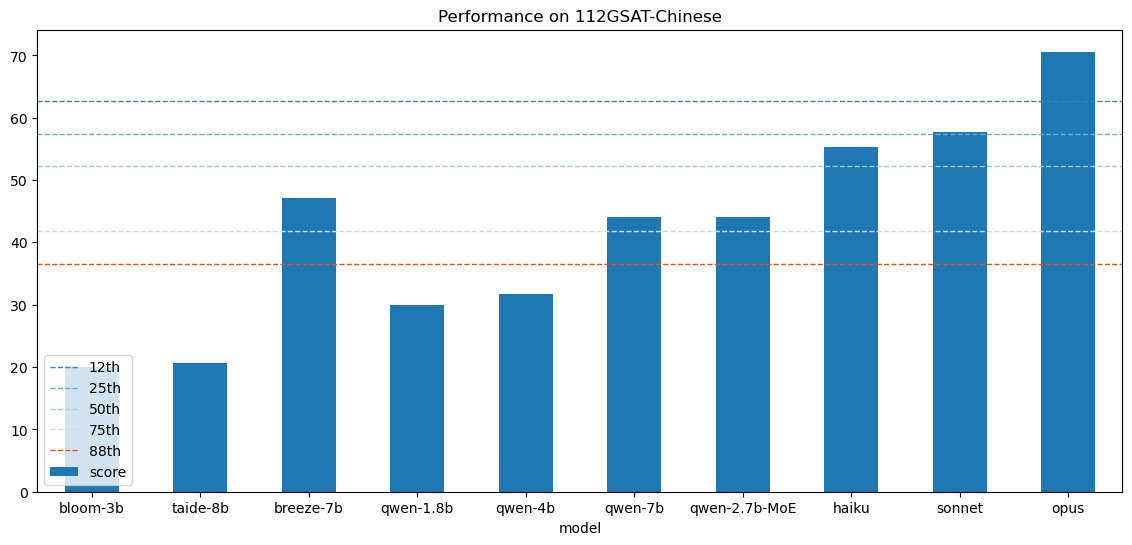

In [5]:
results.plot.bar(x='short_name', y='score', rot=0 , title=f"Performance on {test_name}" , xlabel="model",figsize=(14,6))
cm = plt.cm.get_cmap('tab20c')
plt.axhline(y=62.63,linewidth=1,ls="--" ,color=cm.colors[0], label="12th")
plt.axhline(y=57.41,linewidth=1,ls="--" ,color=cm.colors[1],label="25th")
plt.axhline(y=52.19,linewidth=1,ls="--" ,color=cm.colors[2], label="50th")
plt.axhline(y=41.75,linewidth=1,ls="--" ,color=cm.colors[3], label="75th")
plt.axhline(y=36.54,linewidth=1,ls="--" ,color=cm.colors[4], label="88th")
plt.legend()